In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [02:59<00:00, 29.7MB/s]
100% 5.11G/5.11G [02:59<00:00, 30.5MB/s]


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lyft-udacity-challenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.7 MB/s eta 0:00:00


In [38]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
import os
import numpy as np 
import pandas as pd 

import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Activation, Reshape
from keras.models import Model
from keras.layers import BatchNormalization
import tensorflow_addons as tfa
from google.colab import files
import json

Text(0.5, 1.0, 'Segmentation')

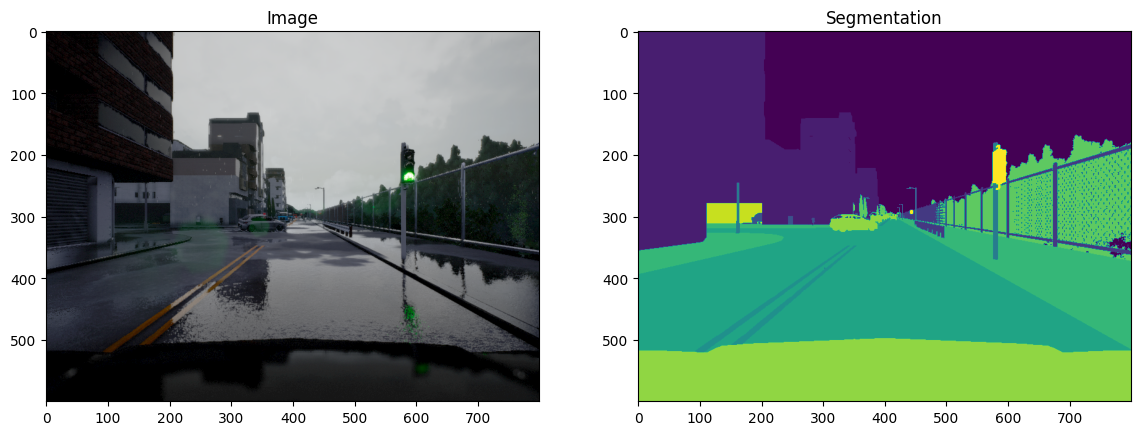

In [ ]:
image_path = ('/content/dataA/dataA/CameraRGB/')
mask_path = ('/content/dataA/dataA/CameraSeg/')
test_path = ('/content/dataB/dataB/CameraRGB/')
test_mask = ('/content/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img =  imageio.imread(image_list[12])
mask = imageio.imread(mask_list[12])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [ ]:
len(test_mask_list)

1000

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

UNET model  input 256*256 classes 23

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):    
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x) # upsample
    x = layers.concatenate([x, conv_features]) # concatenate
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def first_unet_model():
    inputs = layers.Input(shape=(256,256,3))
    # encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    # bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    # output
    outputs = layers.Conv2D(23, 1, padding="same", activation = "softmax")(u9)
    # model
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = first_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

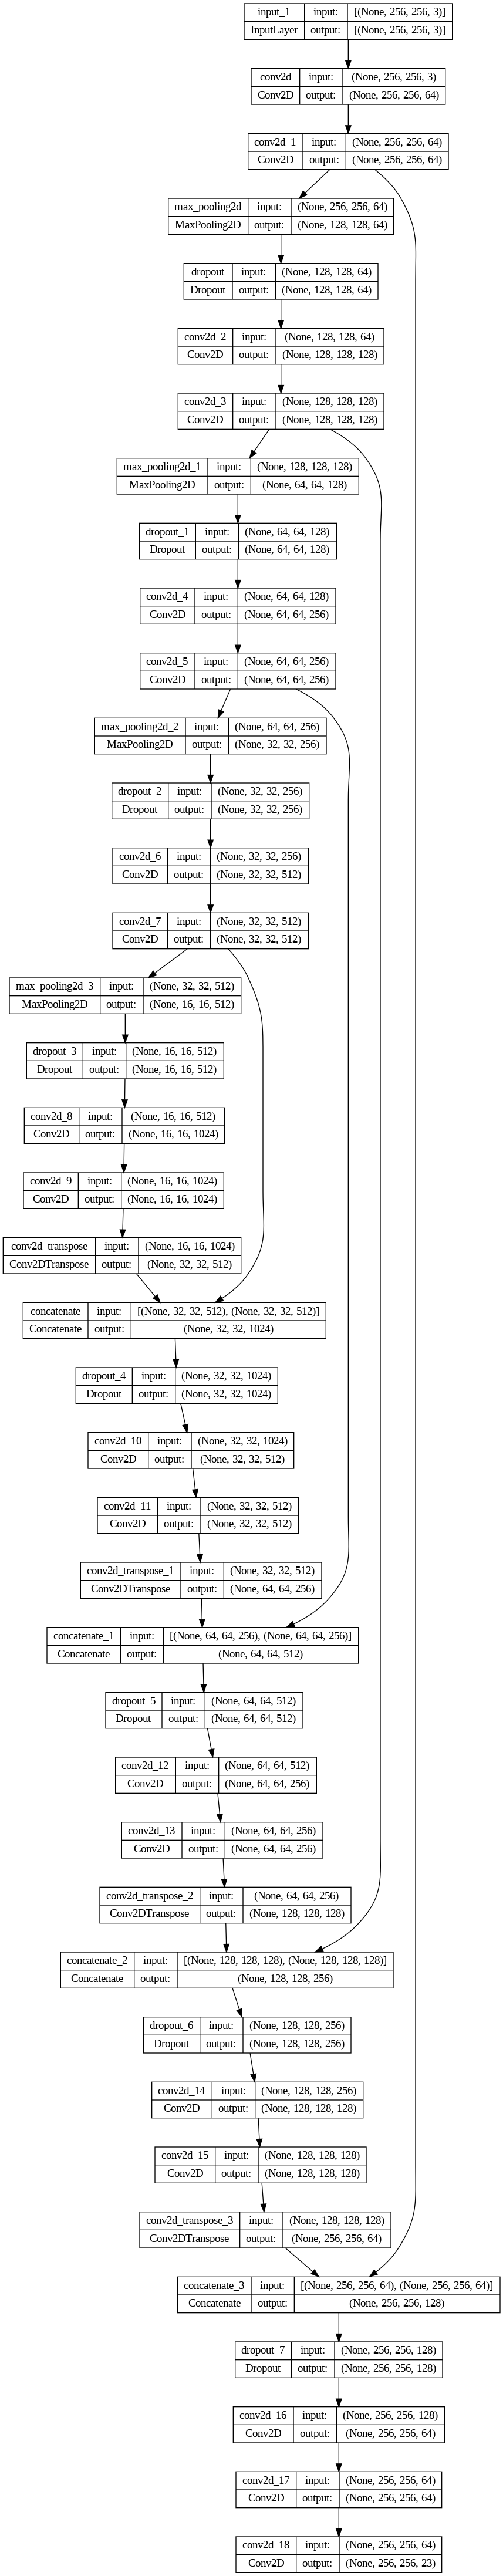

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

Losses and Callbacks

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
checkpoint_dir = '/content/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'weights_{epoch:02d}.h5'),
    save_weights_only=True,
    verbose=1
)


Compile the model

In [ ]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

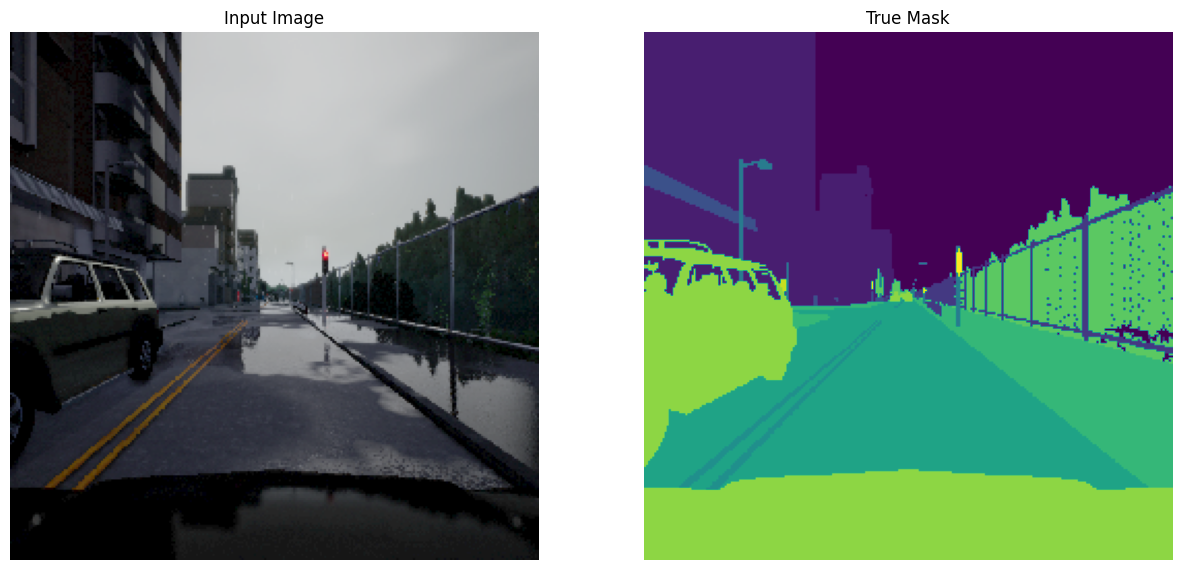

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Run the model

In [35]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

model_history = unet_model.fit(
    train_dataset,
    validation_data=tests_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.1298 - updated_mean_io_u_1: 0.6316 - accuracy: 0.9580
Epoch 31: saving model to /content/checkpoints/weights_31.h5
32/32 [==============================] - 102s 3s/step - loss: 0.1298 - updated_mean_io_u_1: 0.6316 - accuracy: 0.9580 - val_loss: 0.1363 - val_updated_mean_io_u_1: 0.6321 - val_accuracy: 0.9564
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.1338 - updated_mean_io_u_1: 0.6288 - accuracy: 0.9570
Epoch 32: saving model to /content/checkpoints/weights_32.h5
32/32 [==============================] - 75s 2s/step - loss: 0.1338 - updated_mean_io_u_1: 0.6288 - accuracy: 0.9570 - val_loss: 0.1218 - val_updated_mean_io_u_1: 0.6471 - val_accuracy: 0.9611
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.1303 - updated_mean_io_u_1: 0.6337 - accuracy: 

1/1 [==============================] - 0s 426ms/step


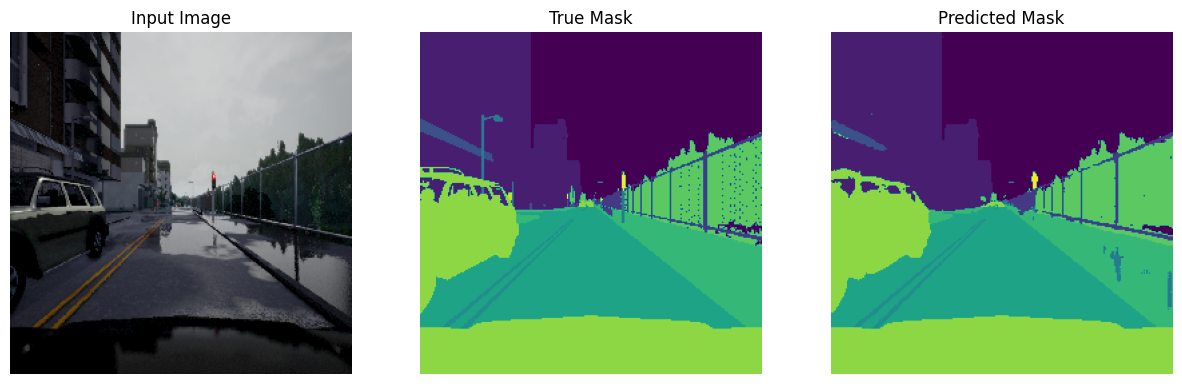

1/1 [==============================] - 0s 57ms/step


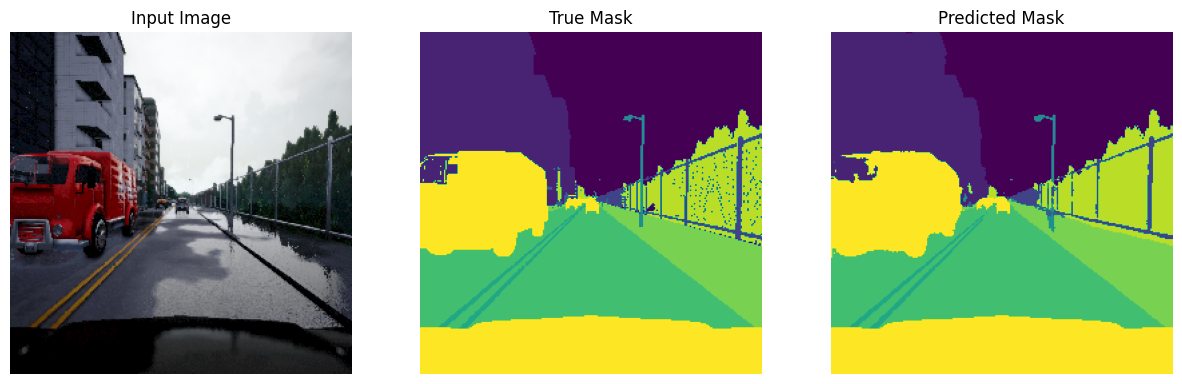

1/1 [==============================] - 0s 69ms/step


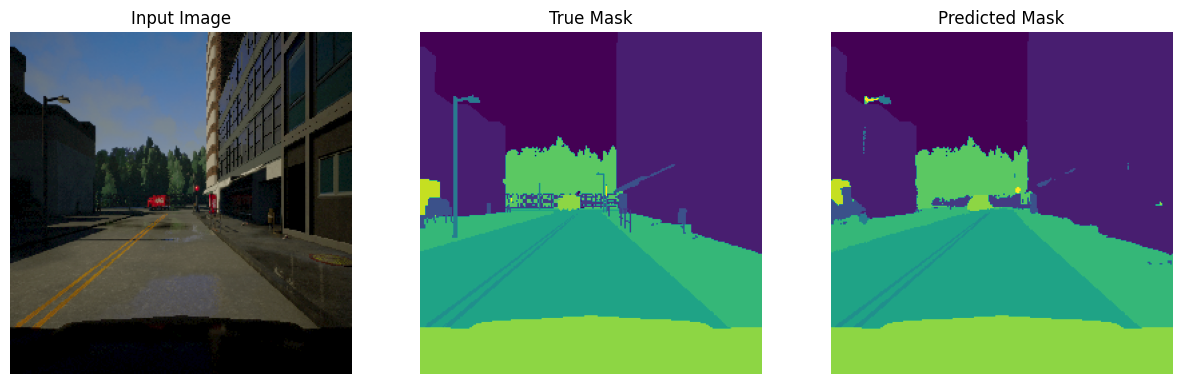

1/1 [==============================] - 0s 36ms/step


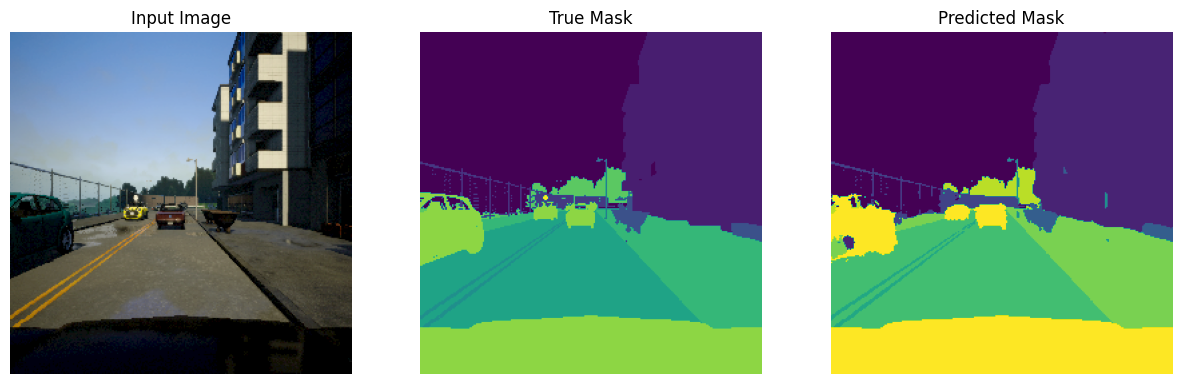

1/1 [==============================] - 0s 52ms/step


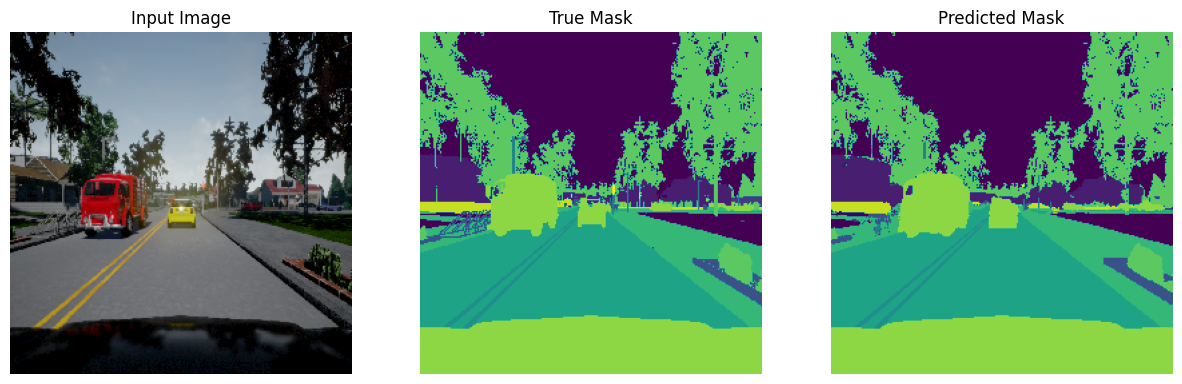

In [36]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(tests_dataset, 5)

In [39]:
# save the history to a file
history_file = 'history_unet_256_lyft_dataset_50_epochs.json'
with open(history_file, 'w') as f:
    json.dump(model_history.history, f)
# download the history file
files.download(history_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>